# Hotel Database
## Assignment

Design, populate, and query a database for a hotel reservation system with the following business rules:

1. The hotel has a number of rooms of two types: Deluxe and Suite
2. For every night, some rooms are made available for reservation for a specific price.
3. A guest can make a reservation for an avavilable room for one night. The reservation must include credit card payment info. At most one reservation can be made per night per room.
4. A guest can check into a room that has been reserved. An attempt to check in without a reservation will generate an error.
5. A guest can check out only after checking in. An attempt to check out multiple times or check out without checking in will generate an error.

Your Python code should provide the following:

1. A section to create the tables. The design must be in 3rd normal form following the conventions discussed in class and enforcing the business rules above.

2. Provide code to populate rooms and room availability with prices.

3. The function `reserve_room(room, date, guest_name, credit_card)` to make a reservation. A script that populates at least 300 reservations (e.g. use `faker`)

4. The functions `checkin(room, date)` and `checkout(room, date)` to check guests in and out. Write a script that invokes `checkin` and `checkout` for a buncha guests.  Demonstrate that that the functions enforces the rules of the business.

5. Write a query to list all guests who have stayed in a given room in 2021.

6. Write a query to list all dates on which a specific guest stayed at the hotel.



# Define the database

In [1]:
import datajoint as dj
schema = dj.Schema('shared_hotel')

[2022-11-01 18:06:42,412][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-11-01 18:06:42,805][INFO]: Connected dimitri@db.ust-data-sci.net:3306


In [2]:
@schema
class Room(dj.Manual):
    definition = """
    room : int
    --- 
    room_type : enum('Deluxe', 'Suite')
    """

In [3]:
@schema
class RoomAvailable(dj.Manual):
    definition = """
    -> Room
    date : date 
    ---
    price : decimal(6, 2)
    """

In [4]:
@schema
class Guest(dj.Manual):
    definition = """
    guest_id : int unsigned
    --- 
    guest_name : varchar(60)
    index(guest_name)
    """

In [5]:
@schema
class Reservation(dj.Manual):
    definition = """
    -> RoomAvailable
    ---
    -> Guest
    credit_card : varchar(80)
    """

In [6]:
@schema
class CheckIn(dj.Manual):
    definition = """
    -> Reservation
    """

In [7]:
@schema
class CheckOut(dj.Manual):
    definition = """
    -> CheckIn
    """

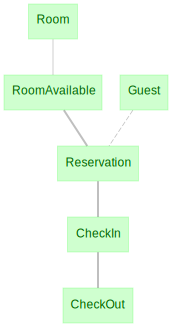

In [8]:
dj.Diagram(schema)

# Populate Room Availability

In [9]:
import faker
import random
import datetime
import tqdm
fake = faker.Faker()

In [10]:
# populate rooms
Room.insert((i, "Deluxe" if i%2 else "Suite") for i in range(80))

In [11]:
# Populate Room availability: 45 days starting on start_date
start_date = datetime.date(2021, 10, 1)
days = 45

for day in tqdm.tqdm(range(days)):
    price = random.randint(40, 350) 
    RoomAvailable.insert(
        dict(key, 
             date=start_date + datetime.timedelta(days=day), 
             price=price) for key in Room.fetch('KEY'))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:03<00:00, 11.92it/s]


# Functions 

In [14]:
class HotelException(Exception): pass
class RoomUnavailable(HotelException): pass
class RoomAlreadyReserved(HotelException): pass
class AlreadyChecked(HotelException): pass
class NoReservation(HotelException): pass
class NotCheckedIn(HotelException): pass

In [15]:
def reserve_room(room, date, guest_name, credit_card):
    # lookup guest by name
    keys = (Guest & {'guest_name': guest_name}).fetch('KEY')
    
    if keys:
        # if multiple found, use the first, for example
        key = keys[0]  
    else:
        # if not registered before, create a new guest id
        key = dict(guest_id=random.randint(0, 2**32-1))
        Guest.insert1(dict(key, guest_name=guest_name))
    
    try:
        Reservation.insert1(
            dict(key, room=room, date=date, credit_card=credit_card))
    except dj.errors.DuplicateError:
        raise RoomAlreadyReserved(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise RoomUnavailable(room, date.isoformat()) from None

In [16]:
def check_in(room, date):
    try:
        CheckIn.insert1(dict(room=room, date=date))
    except dj.errors.DuplicateError:
        raise AlreadyChecked(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise NoReservation(room, date.isoformat()) from None

In [17]:
def check_out(room, date):
    try:
        CheckOut.insert1(dict(room=room, date=date))
    except dj.errors.DuplicateError:
        raise AlreadyChecked(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise NotCheckedIn(room, date.isoformat()) from None

# Operations

In [18]:
# make a bunch of random reservations

number_of_guests = 100
max_nights = 20

for i in tqdm.tqdm(range(number_of_guests)):
    guest = fake.name()
    credit_card=' '.join((fake.credit_card_number(), 
                          fake.credit_card_expire(), 
                          fake.credit_card_security_code()))
    
    for j in range(random.randint(1, max_nights)):
        date =  fake.date_between_dates(start_date, start_date+datetime.timedelta(days=45))
        room = random.randint(0, 80)
        try:
            reserve_room(room, date, guest, credit_card)
        except HotelException as e:
            print(repr(e))
            
# show successful reservations
Reservation()

  8%|████████████▉                                                                                                                                                     | 8/100 [00:06<01:16,  1.21it/s]

RoomUnavailable(80, '2021-10-01')


  9%|██████████████▌                                                                                                                                                   | 9/100 [00:07<01:14,  1.22it/s]

RoomAlreadyReserved(51, '2021-11-04')


 11%|█████████████████▋                                                                                                                                               | 11/100 [00:09<01:27,  1.02it/s]

RoomUnavailable(80, '2021-11-09')


 12%|███████████████████▎                                                                                                                                             | 12/100 [00:10<01:20,  1.09it/s]

RoomAlreadyReserved(2, '2021-10-29')


 21%|█████████████████████████████████▊                                                                                                                               | 21/100 [00:18<01:07,  1.16it/s]

RoomUnavailable(80, '2021-10-24')
RoomAlreadyReserved(11, '2021-11-12')


 22%|███████████████████████████████████▍                                                                                                                             | 22/100 [00:18<00:58,  1.34it/s]

RoomAlreadyReserved(58, '2021-10-29')
RoomUnavailable(80, '2021-10-16')
RoomUnavailable(80, '2021-10-22')
RoomAlreadyReserved(32, '2021-11-11')


 23%|█████████████████████████████████████                                                                                                                            | 23/100 [00:19<01:09,  1.11it/s]

RoomAlreadyReserved(71, '2021-10-28')
RoomAlreadyReserved(16, '2021-10-28')


 25%|████████████████████████████████████████▎                                                                                                                        | 25/100 [00:20<00:49,  1.52it/s]

RoomUnavailable(80, '2021-10-19')
RoomAlreadyReserved(38, '2021-10-26')


 26%|█████████████████████████████████████████▊                                                                                                                       | 26/100 [00:21<01:01,  1.20it/s]

RoomAlreadyReserved(70, '2021-11-11')


 28%|█████████████████████████████████████████████                                                                                                                    | 28/100 [00:22<00:47,  1.52it/s]

RoomAlreadyReserved(75, '2021-10-14')


 30%|████████████████████████████████████████████████▎                                                                                                                | 30/100 [00:24<00:53,  1.32it/s]

RoomAlreadyReserved(58, '2021-10-29')
RoomAlreadyReserved(64, '2021-10-24')
RoomUnavailable(80, '2021-10-09')


 31%|█████████████████████████████████████████████████▉                                                                                                               | 31/100 [00:26<01:02,  1.11it/s]

RoomAlreadyReserved(44, '2021-10-29')
RoomAlreadyReserved(39, '2021-10-28')


 32%|███████████████████████████████████████████████████▌                                                                                                             | 32/100 [00:27<01:14,  1.10s/it]

RoomAlreadyReserved(9, '2021-10-31')


 33%|█████████████████████████████████████████████████████▏                                                                                                           | 33/100 [00:28<01:12,  1.08s/it]

RoomUnavailable(80, '2021-10-03')


 34%|██████████████████████████████████████████████████████▋                                                                                                          | 34/100 [00:29<01:04,  1.03it/s]

RoomUnavailable(80, '2021-10-18')
RoomAlreadyReserved(44, '2021-11-10')


 35%|████████████████████████████████████████████████████████▎                                                                                                        | 35/100 [00:29<00:55,  1.17it/s]

RoomAlreadyReserved(36, '2021-11-13')


 36%|█████████████████████████████████████████████████████████▉                                                                                                       | 36/100 [00:30<00:47,  1.34it/s]

RoomAlreadyReserved(52, '2021-10-21')


 37%|███████████████████████████████████████████████████████████▌                                                                                                     | 37/100 [00:31<00:54,  1.15it/s]

RoomAlreadyReserved(65, '2021-10-03')


 38%|█████████████████████████████████████████████████████████████▏                                                                                                   | 38/100 [00:32<00:58,  1.05it/s]

RoomAlreadyReserved(30, '2021-10-06')


 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 40/100 [00:34<00:57,  1.04it/s]

RoomAlreadyReserved(55, '2021-10-08')
RoomAlreadyReserved(56, '2021-10-09')
RoomAlreadyReserved(32, '2021-10-28')


 41%|██████████████████████████████████████████████████████████████████                                                                                               | 41/100 [00:36<01:04,  1.09s/it]

RoomAlreadyReserved(56, '2021-10-28')
RoomAlreadyReserved(46, '2021-11-07')
RoomAlreadyReserved(14, '2021-10-19')
RoomAlreadyReserved(34, '2021-10-06')


 42%|███████████████████████████████████████████████████████████████████▌                                                                                             | 42/100 [00:37<01:07,  1.16s/it]

RoomAlreadyReserved(59, '2021-11-13')


 43%|█████████████████████████████████████████████████████████████████████▏                                                                                           | 43/100 [00:38<01:05,  1.15s/it]

RoomAlreadyReserved(45, '2021-10-27')
RoomAlreadyReserved(59, '2021-10-22')


 44%|██████████████████████████████████████████████████████████████████████▊                                                                                          | 44/100 [00:40<01:11,  1.28s/it]

RoomAlreadyReserved(28, '2021-10-09')
RoomAlreadyReserved(42, '2021-10-27')
RoomAlreadyReserved(54, '2021-11-02')


 45%|████████████████████████████████████████████████████████████████████████▍                                                                                        | 45/100 [00:40<00:59,  1.09s/it]

RoomAlreadyReserved(37, '2021-11-12')


 46%|██████████████████████████████████████████████████████████████████████████                                                                                       | 46/100 [00:41<00:54,  1.00s/it]

RoomAlreadyReserved(75, '2021-10-06')
RoomAlreadyReserved(25, '2021-11-02')


 47%|███████████████████████████████████████████████████████████████████████████▋                                                                                     | 47/100 [00:42<00:52,  1.01it/s]

RoomAlreadyReserved(8, '2021-10-12')


 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                   | 48/100 [00:43<00:44,  1.16it/s]

RoomUnavailable(80, '2021-10-13')
RoomAlreadyReserved(73, '2021-10-04')
RoomAlreadyReserved(6, '2021-10-20')


 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                                | 50/100 [00:44<00:34,  1.46it/s]

RoomAlreadyReserved(2, '2021-11-03')
RoomAlreadyReserved(3, '2021-10-23')
RoomAlreadyReserved(34, '2021-10-28')


 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 51/100 [00:44<00:34,  1.44it/s]

RoomAlreadyReserved(24, '2021-10-03')
RoomAlreadyReserved(50, '2021-10-30')


 53%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 53/100 [00:46<00:36,  1.28it/s]

RoomUnavailable(80, '2021-11-12')
RoomAlreadyReserved(68, '2021-10-12')
RoomUnavailable(80, '2021-10-14')
RoomUnavailable(80, '2021-10-04')


 57%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 57/100 [00:50<00:34,  1.26it/s]

RoomAlreadyReserved(44, '2021-10-30')
RoomUnavailable(80, '2021-10-11')


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 58/100 [00:51<00:39,  1.08it/s]

RoomAlreadyReserved(43, '2021-10-06')
RoomAlreadyReserved(32, '2021-11-11')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 60/100 [00:54<00:39,  1.02it/s]

RoomAlreadyReserved(65, '2021-10-23')
RoomAlreadyReserved(56, '2021-11-01')
RoomAlreadyReserved(44, '2021-10-01')


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 61/100 [00:54<00:37,  1.05it/s]

RoomAlreadyReserved(42, '2021-10-10')
RoomAlreadyReserved(16, '2021-10-28')
RoomUnavailable(80, '2021-11-03')


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 62/100 [00:56<00:38,  1.02s/it]

RoomAlreadyReserved(37, '2021-10-07')


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 63/100 [00:57<00:40,  1.09s/it]

RoomAlreadyReserved(25, '2021-11-14')
RoomUnavailable(80, '2021-10-18')
RoomAlreadyReserved(50, '2021-10-30')
RoomAlreadyReserved(36, '2021-10-09')
RoomAlreadyReserved(69, '2021-11-04')


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 65/100 [00:58<00:26,  1.34it/s]

RoomAlreadyReserved(17, '2021-10-13')
RoomAlreadyReserved(6, '2021-10-09')
RoomAlreadyReserved(62, '2021-10-05')


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 68/100 [01:00<00:18,  1.76it/s]

RoomAlreadyReserved(26, '2021-11-12')
RoomAlreadyReserved(28, '2021-11-05')
RoomAlreadyReserved(23, '2021-10-26')
RoomAlreadyReserved(63, '2021-11-08')


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 69/100 [01:01<00:24,  1.28it/s]

RoomAlreadyReserved(71, '2021-10-04')
RoomAlreadyReserved(4, '2021-10-19')
RoomAlreadyReserved(39, '2021-11-02')


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 70/100 [01:02<00:28,  1.05it/s]

RoomAlreadyReserved(23, '2021-11-06')
RoomAlreadyReserved(69, '2021-10-20')
RoomAlreadyReserved(41, '2021-11-03')
RoomAlreadyReserved(66, '2021-11-11')


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 71/100 [01:04<00:31,  1.08s/it]

RoomAlreadyReserved(42, '2021-10-27')
RoomAlreadyReserved(44, '2021-10-28')


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 72/100 [01:05<00:29,  1.07s/it]

RoomAlreadyReserved(43, '2021-11-01')


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 73/100 [01:06<00:28,  1.05s/it]

RoomAlreadyReserved(72, '2021-10-29')
RoomAlreadyReserved(2, '2021-11-11')
RoomAlreadyReserved(11, '2021-10-30')
RoomAlreadyReserved(38, '2021-11-07')


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 74/100 [01:07<00:28,  1.10s/it]

RoomUnavailable(80, '2021-11-04')
RoomAlreadyReserved(42, '2021-10-06')
RoomAlreadyReserved(62, '2021-11-02')


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 75/100 [01:08<00:26,  1.08s/it]

RoomUnavailable(80, '2021-10-09')
RoomAlreadyReserved(13, '2021-10-22')


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 76/100 [01:08<00:21,  1.14it/s]

RoomAlreadyReserved(58, '2021-11-04')


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 77/100 [01:09<00:16,  1.44it/s]

RoomAlreadyReserved(52, '2021-10-26')
RoomAlreadyReserved(77, '2021-11-13')


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 80/100 [01:10<00:11,  1.70it/s]

RoomAlreadyReserved(53, '2021-11-07')
RoomAlreadyReserved(44, '2021-11-04')
RoomAlreadyReserved(56, '2021-11-09')
RoomAlreadyReserved(43, '2021-10-01')


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 81/100 [01:12<00:15,  1.23it/s]

RoomAlreadyReserved(32, '2021-10-16')
RoomUnavailable(80, '2021-10-29')


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 84/100 [01:14<00:09,  1.67it/s]

RoomAlreadyReserved(15, '2021-11-06')
RoomAlreadyReserved(44, '2021-10-06')


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 85/100 [01:15<00:10,  1.41it/s]

RoomAlreadyReserved(59, '2021-11-05')
RoomAlreadyReserved(24, '2021-10-04')
RoomAlreadyReserved(37, '2021-10-23')
RoomAlreadyReserved(46, '2021-10-25')


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 86/100 [01:16<00:12,  1.09it/s]

RoomAlreadyReserved(78, '2021-10-26')
RoomAlreadyReserved(59, '2021-11-07')


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 87/100 [01:16<00:10,  1.27it/s]

RoomAlreadyReserved(78, '2021-10-26')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 88/100 [01:17<00:09,  1.23it/s]

RoomAlreadyReserved(10, '2021-11-09')
RoomAlreadyReserved(56, '2021-11-06')


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 89/100 [01:18<00:08,  1.31it/s]

RoomAlreadyReserved(71, '2021-10-04')
RoomUnavailable(80, '2021-10-29')
RoomAlreadyReserved(74, '2021-10-11')
RoomAlreadyReserved(22, '2021-10-03')
RoomAlreadyReserved(64, '2021-10-02')


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 90/100 [01:19<00:09,  1.03it/s]

RoomAlreadyReserved(60, '2021-11-14')
RoomAlreadyReserved(27, '2021-11-04')
RoomAlreadyReserved(8, '2021-10-05')
RoomAlreadyReserved(6, '2021-11-05')
RoomAlreadyReserved(33, '2021-10-23')


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 91/100 [01:21<00:09,  1.10s/it]

RoomUnavailable(80, '2021-10-21')


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 92/100 [01:21<00:07,  1.06it/s]

RoomUnavailable(80, '2021-10-02')
RoomAlreadyReserved(37, '2021-10-20')


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 94/100 [01:22<00:03,  1.64it/s]

RoomAlreadyReserved(6, '2021-11-05')
RoomAlreadyReserved(55, '2021-11-09')
RoomAlreadyReserved(35, '2021-10-07')
RoomAlreadyReserved(57, '2021-11-05')


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 95/100 [01:23<00:03,  1.51it/s]

RoomAlreadyReserved(43, '2021-10-05')
RoomAlreadyReserved(39, '2021-10-14')
RoomAlreadyReserved(21, '2021-11-04')
RoomAlreadyReserved(12, '2021-10-02')


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 96/100 [01:23<00:02,  1.59it/s]

RoomAlreadyReserved(70, '2021-11-04')
RoomAlreadyReserved(52, '2021-10-04')
RoomAlreadyReserved(75, '2021-10-29')
RoomAlreadyReserved(67, '2021-10-02')


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 97/100 [01:24<00:02,  1.34it/s]

RoomAlreadyReserved(6, '2021-11-05')


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 98/100 [01:25<00:01,  1.59it/s]

RoomAlreadyReserved(48, '2021-10-19')


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [01:26<00:00,  1.46it/s]

RoomAlreadyReserved(52, '2021-11-14')
RoomAlreadyReserved(9, '2021-11-08')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


room,date,guest_id,credit_card
0,2021-10-14,2467043059,2453673541841351 11/23 462
0,2021-10-18,845826740,4528881031739606163 04/28 5583
0,2021-10-24,869198512,4772595821214195133 12/26 759
0,2021-11-02,16581998,30391204843665 11/28 632
0,2021-11-05,120232026,4348858747347957 09/29 279
0,2021-11-08,522963624,4045810724428447888 11/23 135
1,2021-10-02,576988272,6515232227314782 05/25 632
1,2021-10-03,522963624,4045810724428447888 11/23 135
1,2021-10-05,1231311424,30570944113766 04/31 962
1,2021-10-14,3760759381,3558142798582912 04/27 188


In [19]:
Guest()

guest_id,guest_name
1662864156,Adam Schwartz
869198512,Alexandra Sampson
3953620611,Alexis Arias
1751304781,Amy Murphy
576988272,Amy Ray
500507429,Andrew Barnes
2712870417,Arthur Shepherd
120232026,Ashley Williams
114175943,Barbara Grant
2549454580,Becky Harrington


In [20]:
# Try check in

check_in(2, datetime.date(2021, 10, 2))

NoReservation: (2, '2021-10-02')

In [21]:
# checkin a bunch of people
checkins = random.sample(Reservation().fetch('KEY'), k=int(0.9*len(Reservation())))
for r in tqdm.tqdm(checkins):
    check_in(**r)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 835/835 [00:34<00:00, 24.37it/s]


In [ ]:
CheckIn()

In [22]:
# Try duplicate checkin
check_in(**checkins[0])

AlreadyChecked: (26, '2021-10-31')

In [23]:
# Try checkout

check_out(2, datetime.date(2021, 10, 2))

NotCheckedIn: (2, '2021-10-02')

In [24]:
# checkout a bunch of people
checkouts = random.sample(CheckIn().fetch('KEY'), k=int(0.9*len(CheckIn())))
for r in tqdm.tqdm(checkouts):
    check_out(**r)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [00:30<00:00, 24.70it/s]


In [25]:
# try duplicate checkout

check_out(**checkouts[0])

AlreadyChecked: (29, '2021-10-03')

# Queries 

## Query 1: List all guests who have stayed in room 1

In [26]:
Guest & (Reservation & (CheckIn & 'room=1'))

guest_id,guest_name
576988272,Amy Ray
522963624,Christopher Smith
1231311424,Dylan Vincent
3760759381,Jamie Atkinson
26727245,Brandon Villarreal
120232026,Ashley Williams
2783887783,Emily Caldwell
290179231,Judy Adkins


In [27]:
Guest & (Reservation * CheckIn & 'room=1')

guest_id,guest_name
576988272,Amy Ray
522963624,Christopher Smith
1231311424,Dylan Vincent
3760759381,Jamie Atkinson
26727245,Brandon Villarreal
120232026,Ashley Williams
2783887783,Emily Caldwell
290179231,Judy Adkins


In [28]:
_.make_sql()

'SELECT `guest_id`,`guest_name` FROM `shared_hotel`.`guest` WHERE ((`guest_id`) in (SELECT `guest_id` FROM `shared_hotel`.`reservation` NATURAL JOIN `shared_hotel`.`check_in` WHERE (room=1)))'

## Query 2: List all nights when a guest stayed at a hotel

In [29]:
# pick a guest
guest = random.choice(Guest().fetch('KEY'))

In [30]:
guest

{'guest_id': 522963624}

In [31]:
(Reservation * CheckIn & guest).proj()

room,date
0,2021-11-08
1,2021-10-03
4,2021-10-04
11,2021-10-16
24,2021-10-08
36,2021-10-01
39,2021-10-22
54,2021-11-10
74,2021-10-12
74,2021-10-29
